In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


## 1. Load Data set

这里我们依然使用Keras的Minist数据集.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(x_train.shape[0],-1) / 255
x_test = x_test.reshape(x_test.shape[0],-1) / 255

## 2. Initialization

使用Tensorflow初始化weights and bias.

In [4]:
def initializer_parameters(L,layers):
    """
    Arguments:
    ---------
        L: #input'units + hidden layers'units
        layers: hidden layers's units
    Return:
    ------
        parameters: include weights and bias.
    Note:
    ----
        In this case, weights's initializer is "He".
    """
    parameters = {}
    initializer_W = tf.keras.initializers.he_normal(seed=1)
    initializer_b = tf.keras.initializers.zeros()
    for l in range(L-1):
        parameters['W'+str(l+1)] = tf.get_variable('W'+str(l+1),[layers[l],layers[l+1]],initializer=initializer_W)
        parameters['b'+str(l+1)] = tf.get_variable('b'+str(l+1),[1,layers[l+1]],initializer=initializer_b)
    return parameters

## 3. Forward

构建forward Propagation.

In [5]:
def forward(L,X,parameters):
    """
    Implement forward propagation
    
    Arguments:
    ---------
        L: #input'units + hidden layers'units
        X: data set, shape like [n_sample,features]
        parameters: include weights and bias.
        
    Return:
    ------
        X: output layer value,
        Notice,it not use activate function,because,we loss function choose:
            tf.nn.softmax_cross_entropy_with_logits_v2.
    
    """
    for l in range(L-1):
        
        W = parameters['W'+str(l+1)]
        b = parameters['b'+str(l+1)]
        
        X = tf.add(tf.matmul(X,W),b)
        if l != L-2:
            X = tf.nn.relu(X)
        else:
            return X

In [6]:
tf.reset_default_graph()
layers = [5,2,10]
layers.insert(0,x_train.shape[1])
L = len(layers)
parameters = initializer_parameters(L,layers)
out = forward(L,tf.cast(x_train,tf.float32),parameters)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('out shape is:',sess.run(out).shape)

Instructions for updating:
Colocations handled automatically by placer.
out shape is: (60000, 10)


可以看到整体向前传播的逻辑没有错误,那么接下来我们开始构建Softmax Model.

------------

## 4. Build Softmax Model

之前我们拆分Mini-Batch是使用Numpy的形式,现在我们采用Tensorflow自带的函数来拆分数据.

```python
dataset = tf.data.Dataset.from_tensor_slices((X,y_hot)).repeat()
dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)
iter_ = dataset.make_initializable_iterator()
mini_x, mini_y = iter_.get_next()```

(1) 我们依照```tf.data.Dataset.from_tensor_slices```来拆分数据样本和标签,我这里是采用占位符形式,repeat表示指定数据集被迭代的次数,如果不指定代表永久循环,通常永久运行循环和在标准循环中直接控制 epoch 的数量可以得到不错的结果.

(2) 我们可以使用```dataset.shuffle```来打乱样本,shuffle是预防过拟合的一个重要措施,默认是在每一个 epoch 中将数据集 shuffle 一次,参数 buffer_size,下一个元素将从该固定大小的缓存中均匀地选取.

(3) 我们使用```dataset.make_initializable_iterator()```来初始化迭代器,注意在大样本的情况下迭代器的效率会比直接for loop的效率高很多.

(4) 最后每次调用,我们使用```iter_.get_next()```来获取元素.

需要注意的是,我们使用了Dataset类进行划分数据,那么我们就可以直接应用于training model.

```python
parameters = initializer_parameters(L,layers)
out = forward(L,mini_x,parameters)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=mini_y))
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)```

由于我们最后进行测试的时候是整体的train/validation set,而不是划分出来的mini_x,mini_y,所以我们就要重新编制一个testing model code.
用于测试用,主要区别在于```place holder```的取值.
```python
out_test = forward(L,X,parameters)
cost_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_test,labels=y_hot))
softmax_y = tf.nn.softmax(logits=out_test,axis=1)
correct = tf.equal(y,tf.argmax(softmax_y,axis=1))
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))```

最后我们开启Tensorflow训练,先使用```sess.run(iter_.initializer,feed_dict={X:data,y_hot:labels_hot})```来将数据放入Dataset类中进行划分.另外因为我们是使用的mini_x,mini_y,所以我们不需要在feed任何参数.

**Reference:**

[如何在TensorFlow中高效使用数据集](https://www.jiqizhixin.com/articles/03137)

**PS:**

<span style="color:red">目前来说不要使用```tf.one_hot()```进行hot矩阵的转换,因为其是一个tensor,如果使用那么计算速度会非常的慢(个人认为主要还是因为TF将hot矩阵也进行梯度渐变了).所以我们还是使用numpy的变化形式```np.eye()```</span>

In [26]:
def SoftmaxModel(layers,data,labels,val_data,val_labels,lr,epochs,BATCH_SIZE):
    """
    Build Softmax model
    Arguments:
    ---------
        layers: hidden layers's units
        data: training date set.
        labels: training labels.
        val_data: validation data set.
        val_labels: validation labels.
        lr: learning rate.
        epochs: #iterate
        BATCH_SIZE: batch size in Mini-Batch.
    Returns:
    -------
    train_loss_list: include train set  loss value in every 100 epoch.
    val_loss_list: include val data set  loss value in every 100 epoch.
    train_accs_list: include train set  correct rate  in every 100 epoch.
    val_accs_list: include val set correct rate in every 100 epoch.
        
    """
    
    ops.reset_default_graph() # celar graph
    
    # Pretreatment
    m,n = data.shape
    n_classes = len(np.unique(labels))
    layers.insert(0,n)
    L = len(layers)
    labels_hot = np.eye(n_classes)[labels]
    val_labels_hot = np.eye(n_classes)[val_labels]
    
    # Create place holder
    X = tf.placeholder(tf.float32,[None,n])
    y_hot = tf.placeholder(tf.float32,[None,n_classes])
    y = tf.placeholder(tf.int64,[None,])
    
    # split data,using tensorflow.
    dataset = tf.data.Dataset.from_tensor_slices((X,y_hot)).repeat()
    dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)
    iter_ = dataset.make_initializable_iterator()
    mini_x, mini_y = iter_.get_next()
    
    # training model code.
    parameters = initializer_parameters(L,layers)
    out = forward(L,mini_x,parameters)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out,labels=mini_y))
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    # testing model code.
    out_test = forward(L,X,parameters)
    cost_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_test,labels=y_hot))
    softmax_y = tf.nn.softmax(logits=out_test,axis=1)
    correct = tf.equal(y,tf.argmax(softmax_y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    
    seed = 0
    init = tf.global_variables_initializer()
    # cache train/validation loss value and accuracy value.
    train_loss_list = []
    val_loss_list = []
    train_accs_list = []
    val_accs_list = []
    with tf.Session() as sess:
        sess.run(init)
        sess.run(iter_.initializer,feed_dict={X:data,y_hot:labels_hot})

        for epoch in range(epochs):
            _ = sess.run(optimizer)
            if epoch % 100 == 0:
                acc_train,loss_train = sess.run([accuracy,cost_test],feed_dict={X:data,y:labels,y_hot:labels_hot})
                acc_val,loss_val = sess.run([accuracy,cost_test],feed_dict={X:val_data,y:val_labels,y_hot:val_labels_hot})
                print('\033[0;35m [{}/{}] loss:{:.4f},acc_train:{:.4f},val_loss:{:.4f},acc_val:{:.4f}\033[0m\r'.format(
                epoch+100,epochs,loss_train,acc_train,loss_val,acc_val),end="",flush=True)
                train_loss_list.append(loss_train)
                val_loss_list.append(loss_val)
                train_accs_list.append(acc_train)
                val_accs_list.append(acc_val)
        return train_loss_list,train_accs_list,val_loss_list,val_accs_list

In [27]:
layers = [25,12,10]
train_loss,train_accs,val_loss,val_accs= SoftmaxModel(layers,x_train,y_train,x_test,y_test,lr=0.001,epochs=4000,
                                                      BATCH_SIZE=64)

可以看到在当前NN下,训练集的正确率在96%,验证集的正确率在95%左右.接下去让我们来绘制一下loss和accuracy.

## 5. PLot Loss/Accuracy

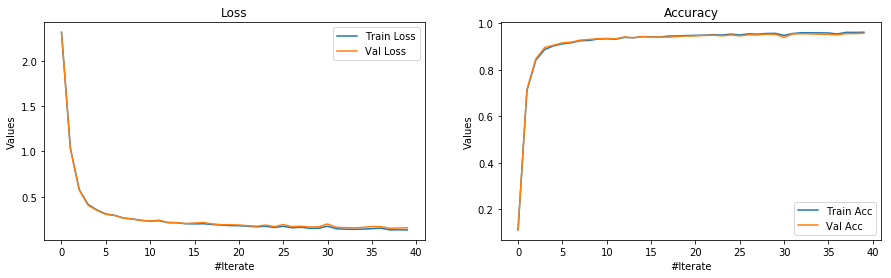

In [28]:
figure = plt.figure(figsize=(15,4))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(train_loss,label="Train Loss")
ax1.plot(val_loss,label="Val Loss")
ax1.set_title('Loss')
ax1.set_xlabel('#Iterate')
ax1.set_ylabel('Values')
ax1.legend()

ax2 = figure.add_subplot(1,2,2)
ax2.plot(train_accs,label="Train Acc")
ax2.plot(val_accs,label="Val Acc")
ax2.set_title('Accuracy')
ax2.set_xlabel('#Iterate')
ax2.set_ylabel('Values')
ax2.legend()

可以看出使用tensorflow方式拆分Mini-Batch的效果比我们单纯使用Numpy的效果会好很多,train/validation两者没有任何过拟合的现象.